In [1]:
%load_ext autoreload
%autoreload 2

In [153]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='7'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=6,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=1,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-gap-select-mstcn/",
    project_name="breakfast-split-1",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

config.output_dir = config.output_dir + f"split{config.split}"
if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)
config.output_dir = config.output_dir +  "/"
print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 6, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 1, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-gap-select-mstcn/split1/', 'project_name': 'breakfast-split-1', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split1.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split1.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1460
Number of videos not found in train fold is 0
Number of videos logged in test fold is 252
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
df=pd.read_csv(config.label_id_csv)
label_id_to_label_name = {}
label_name_to_label_id_dict = {}
for i, ele in df.iterrows():
    label_id_to_label_name[ele.label_id] = ele.label_name
    label_name_to_label_id_dict[ele.label_name] = ele.label_id

In [10]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [11]:
# selected_frames_dict = pickle.load(open("data/breakfast_len_assum_annotations.pkl", 'rb'))
# loaded_vidid_selected_frames
boundary_frames_dict = pickle.load(open("data/breakfast_boundary_annotations.pkl", "rb"))
# video_id_boundary_frames

In [16]:
selected_frames_dict = pickle.load(open("data/breakfast_gap_selected_frames.pkl", "rb"))
print(selected_frames_dict)

{'P26_cam02_P26_scrambledegg.txt': ([(17, 'crack_egg'), (1013, 'add_saltnpepper'), (1590, 'pour_oil'), (2309, 'stirfry_egg'), (3362, 'SIL')], True, False, [(0, 'SIL'), (17, 'crack_egg'), (726, 'stir_egg'), (1013, 'add_saltnpepper'), (1274, 'stir_egg'), (1590, 'pour_oil'), (1939, 'pour_egg2pan'), (2309, 'stirfry_egg'), (2949, 'put_egg2plate'), (3362, 'SIL')]), 'P44_webcam01_P44_salat.txt': ([(101, 'take_plate'), (2238, 'cut_fruit'), (3323, 'cut_fruit')], True, True, [(39, 'SIL'), (101, 'take_plate'), (762, 'take_knife'), (2238, 'cut_fruit'), (2730, 'peel_fruit'), (3323, 'cut_fruit'), (4894, 'SIL')]), 'P53_webcam02_P53_cereals.txt': ([(3, 'SIL'), (331, 'pour_milk'), (841, 'SIL')], False, False, [(3, 'SIL'), (236, 'pour_cereals'), (331, 'pour_milk'), (605, 'stir_cereals'), (841, 'SIL')]), 'P21_webcam02_P21_coffee.txt': ([(179, 'pour_coffee')], True, True, [(0, 'SIL'), (179, 'pour_coffee'), (263, 'SIL')]), 'P15_cam01_P15_scrambledegg.txt': ([(16, 'pour_oil'), (1123, 'stirfry_egg'), (1605, 

In [112]:
loaded_mean_var_actions = pickle.load(open("data/breakfast_meanvar_actions.pkl", "rb"))
mat_poisson = pickle.load(open("data/breakfast_possion_class_dict.pkl", "rb"))

def get_possion_prob(minlen, maxlen, cur_class):
    prob = mat_poisson[label_id_to_label_name[cur_class]][minlen:maxlen]
    return torch.tensor(prob)


def get_possion_prob_for_all_class(minlen, maxlen):
    ele_list = []
    for i in range(config.num_class):
        prob = mat_poisson[label_id_to_label_name[i]][minlen:maxlen]
        ele_list.append(torch.tensor(prob))
    return torch.stack(ele_list, dim=-1)

In [44]:
prob_video_each_segment_dict = {}

In [199]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels, first_ele_flag, last_ele_flag, vidid):
    prob_each_segment = []
    LOW_VAL = -10000000
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    prev_boundary = 0

    if first_ele_flag is True:
        cur_ele = 0
        label_cur_ele = config.num_class - 1
        next_ele = selected_frames[0]
        label_next_ele = labels[0]
        
        indices = torch.arange(cur_ele, next_ele)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
        
        prob = torch.softmax((left_sum + right_sum), dim=0)
        prev_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)


    for i, cur_ele in enumerate(selected_frames[:-1]):
        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[i]
        label_next_ele = labels[i + 1]
        seg_len = next_ele - cur_ele
        mat_b1_b2_c_prob = LOW_VAL * torch.ones((seg_len, seg_len, config.num_class), dtype=cumsum_feat.dtype)
        b1_prior = get_possion_prob(cur_ele-prev_boundary, next_ele-1-prev_boundary, label_cur_ele)
        
        for b1 in range(cur_ele, next_ele - 1):

            cur_boundary_len = b1 - prev_boundary
            strt_index = cumsum_feat[cur_ele - 1, label_cur_ele] if cur_ele > 0 else 0
            
            left_sum = (cumsum_feat[b1, label_cur_ele] - strt_index)
            right_sum = cumsum_feat[next_ele - 1, label_next_ele] - cumsum_feat[b1+1:next_ele, label_next_ele] # mid_seg_len
            
            mid_sum = (cumsum_feat[b1+1:next_ele, :] - cumsum_feat[b1, :])  # mid_seg_len
            
            b2_prior = get_possion_prob_for_all_class(1, next_ele-b1)  # mid_seg_len x num_class
            
            mat_b1_b2_c_prob[b1-cur_ele, b1+1-cur_ele:next_ele-cur_ele] = (left_sum + right_sum[:,None] + mid_sum).cpu() \
                                                                            + b1_prior[b1-cur_ele] + b2_prior

        mat_b1_b2_c_prob[:, :, label_cur_ele] = LOW_VAL
        mat_b1_b2_c_prob[:, :, label_next_ele] = LOW_VAL
        mat_b1_b2_c_prob = torch.softmax(mat_b1_b2_c_prob.flatten(), dim=0).reshape((seg_len, seg_len, config.num_class))

        prev_boundary = round(torch.sum(torch.sum(mat_b1_b2_c_prob[:,1:,:], axis=(0,2)).squeeze() * \
                        torch.arange(cur_ele + 1, next_ele, 1)).item())
        if prev_boundary==0:
            print(f'Estimated boundary has become zero! for {vidid} and cur_ele, next_ele {cur_ele, next_ele}')
            import pdb
            pdb.set_trace()
        
        prob_each_segment.append(mat_b1_b2_c_prob)
        
    if last_ele_flag is True:
        cur_ele = selected_frames[-1]
        label_cur_ele = labels[-1]
        next_ele = cur_vid_feat.shape[0]
        label_next_ele = config.num_class - 1
        
        indices = torch.arange(cur_ele, next_ele)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:, label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:, label_next_ele]
        
        prob = torch.softmax((left_sum + right_sum), dim=0)
        prev_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [196]:
def calculate_element_probb(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        cur_video_select_frames = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices_and_labels = cur_video_select_frames[0]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
        with torch.no_grad():
            prob_video = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels,
                                              cur_video_select_frames[1], cur_video_select_frames[2], cur_vidid)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [200]:
# Calculating Expectation Step
model.eval()
from time import time

correct = 0.0
total = 0.0
curtime = time()

for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4])

        if i % 10 == 0:
            print(f"iter {i} completed in a total {time() - curtime: .2f} seconds")

iter 0 completed in a total  40.09 seconds
iter 10 completed in a total  342.68 seconds
iter 20 completed in a total  656.62 seconds
iter 30 completed in a total  937.12 seconds
iter 40 completed in a total  1198.93 seconds


Traceback (most recent call last):
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [194]:
calculate_element_probb(prob, item_1, item[4])

> <ipython-input-193-887835a90103>(51)prob_vals_per_segment()
-> mat_b1_b2_c_prob[:, :, label_cur_ele] = LOW_VAL
(Pdb) cur_ele, next_ele
(373, 2029)
(Pdb) torch.max(mat_b1_b2_c_prob)
tensor(-174.1947)
(Pdb) a = torch.softmax(mat_b1_b2_c_prob.flatten()).reshape((seg_len, seg_len, config.num_class))
selected_frames = [373, 2029, 2540, 3222, 4005, 4210]
cur_vid_feat = tensor([[2.0956e-05, 1.4908e-05, 2.5969e-05,  ..., 1.6423e-06, 4.3593e-06,
         9.9512e-01],
        [2.0401e-05, 1.2798e-05, 2.2269e-05,  ..., 1.5037e-06, 3.8202e-06,
         9.9531e-01],
        [2.3030e-05, 1.1868e-05, 2.1246e-05,  ..., 1.4327e-06, 3.8405e-06,
         9.9460e-01],
        ...,
        [2.0833e-02, 2.0833e-02, 2.0833e-02,  ..., 2.0833e-02, 2.0833e-02,
         2.0833e-02],
        [2.0833e-02, 2.0833e-02, 2.0833e-02,  ..., 2.0833e-02, 2.0833e-02,
         2.0833e-02],
        [2.0833e-02, 2.0833e-02, 2.0833e-02,  ..., 2.0833e-02, 2.0833e-02,
         2.0833e-02]], device='cuda:0')
labels = [3, 31, 31

BdbQuit: 

In [183]:
for vid in prob_video_each_segment_dict.keys():
    for seg in prob_video_each_segment_dict[vid]:
        print(torch.isnan(seg).any())

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False)
tensor(False)
tensor(False, device='cuda:0')
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False, device='cuda:0')
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False)
tensor(False, device='cuda:0')
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False, device='cuda:0')
tensor(False)
tensor(False, device='cuda:0')
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False, device='cuda:0')
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False, device='cuda:0')
tensor(False)
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False)
tensor(False, device='cuda:0')
tensor(False)
tensor(False)
tensor(False, device='cuda:0')
tensor(False)
tensor(False, device='cuda:0')
tensor(False)
tensor(False)
tensor(Fals

Predicted class id 12, Class name fry_egg


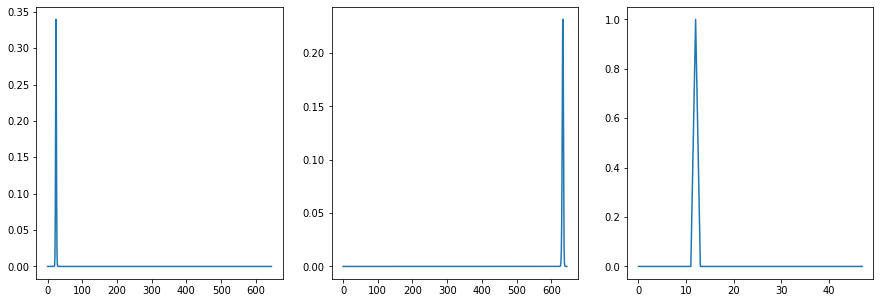

In [172]:
vidname, idx = 'P54_webcam01_P54_friedegg', 2

fig, axe = plt.subplots(1,3,figsize=(15,5))

plt.subplot(1,3,1)
b1_marginal = torch.sum(prob_video_each_segment_dict[vidname][idx], axis=(1,2))
plt.plot(b1_marginal.numpy())

plt.subplot(1,3,2)
b2_marginal = torch.sum(prob_video_each_segment_dict[vidname][idx], axis=(0,2))
plt.plot(b2_marginal.numpy())

plt.subplot(1,3,3)
class_marginal = torch.sum(prob_video_each_segment_dict[vidname][idx], axis=(0,1))
plt.plot(class_marginal.numpy())
print(f'Predicted class id {torch.argmax(class_marginal).item()}, '
      f'Class name {label_id_to_label_name[torch.argmax(class_marginal).item()]}')

tensor(1.0000)


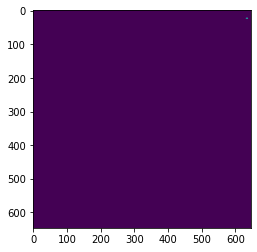

In [177]:
plt.imshow(prob_video_each_segment_dict[vidname][idx][:,:,12])
len_ = prob_video_each_segment_dict[vidname][idx][...,12].shape[0]
sum_prob = 0
for i in range(len_):
    for j in range(i-1,len_):
        sum_prob += prob_video_each_segment_dict[vidname][idx][i,j,12]
print(sum_prob)

In [156]:
boundary_frames_dict[vidname +'.txt'], selected_frames_dict[vidname + '.txt']

[21, 306, 740, 837, 1453, 1522, 1554]

In [192]:
vidname = 'P49_cam01_P49_salat'
boundary_frames_dict[vidname +'.txt'], selected_frames_dict[vidname + '.txt']

([30, 385, 1340, 2380, 2505, 2585, 3050, 3405, 3855, 4070, 4155, 4215, 4228],
 ([(373, 'take_bowl'),
   (2029, 'cut_fruit'),
   (2540, 'cut_fruit'),
   (3222, 'cut_fruit'),
   (4005, 'cut_fruit'),
   (4210, 'stir_fruit')],
  True,
  True,
  [(20, 'SIL'),
   (373, 'take_bowl'),
   (805, 'peel_fruit'),
   (2029, 'cut_fruit'),
   (2470, 'put_fruit2bowl'),
   (2540, 'cut_fruit'),
   (2718, 'peel_fruit'),
   (3222, 'cut_fruit'),
   (3541, 'peel_fruit'),
   (4005, 'cut_fruit'),
   (4103, 'put_fruit2bowl'),
   (4210, 'stir_fruit'),
   (4223, 'SIL')]))

In [16]:
def get_estimated_loss(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
#     global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]

        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames_indices[0]
        if start_ele_idx > 0:
            start_ele_label_idx = selected_frames_labels[0]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames_indices[:-1]):
            next_ele = selected_frames_indices[i + 1]
            label_cur_ele = selected_frames_labels[i]
            label_next_ele = selected_frames_labels[i + 1]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = selected_frames_labels[-1]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames_indices[-1] - 1, \
                                                                         :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [17]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    estimated_boundary_dict = {}
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        
        selected_frames_indices_and_labels = selected_frames_dict[video_id]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_frames_indices[i], selected_frames_indices[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_frames_indices[i]) or (estimated_boundary > selected_frames_indices[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [18]:
def get_boundary_err():
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(boundary_frames_dict[video_id][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = boundary_frames_dict[video_id][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [21]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [22]:
loaded_file=torch.load("/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcnnew-full-supervised-split1/ms-tcn-best-model.wt")
model.load_state_dict(loaded_file)

<All keys matched successfully>

In [21]:
def get_single_random(video_ids, len_frames, device):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((len(video_ids), len_frames), dtype=torch.long, device=device) * (-100)
    for iter_num, cur_vidid in enumerate(video_ids):
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]

        frame_idx_tensor = torch.from_numpy(np.array(selected_frames_indices))
        frame_labels = torch.from_numpy(np.array(selected_frames_labels)).to(device)
        boundary_target_tensor[iter_num, frame_idx_tensor] = frame_labels

    return boundary_target_tensor

In [22]:
weakly_labels = pickle.load(open("data/breakfast_weaklysupervised_labels.pkl", "rb"))

In [23]:
prior_probs = pickle.load(open('data/breakfast_lengthmodel_multinomial_prior.pkl', 'rb'))

In [24]:
import copy
def change_selected_frames(model):
    global selected_frames_dict, prior_probs
    new_selected_frame_dict = {}
    new_prior_probs = {}

    with torch.no_grad():
        for train_idx, item in enumerate(trainloader):
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
            if train_idx % 10 == 0:
                print(f"Completed {train_idx} videos selected frames calculation")
            middle_pred, predictions = model(item_0, src_mask_mse)
            
            for idx, video_id in enumerate(item[4]):
                start = 0
                new_index_label_pair_list = []
                weakly_labels_video = [label_name_to_label_id_dict[wl] for wl in weakly_labels[video_id + ".txt"]]
                cur_video_predictions = predictions[-1][idx][:, :item_1[idx]]
                cur_preds_for_weakly_labels = torch.softmax(cur_video_predictions[weakly_labels_video], dim=0)
                prior_probs_cur_vid = prior_probs[video_id]
                weakly_labels_masked = []
                for i, prob_class in enumerate(cur_preds_for_weakly_labels):
                    prob_class_masked = prob_class * torch.tensor(prior_probs_cur_vid[i], 
                                                                  dtype=prob_class.dtype, device=prob_class.device)
                    weakly_labels_masked.append(prob_class_masked)
                    
                weakly_labels_masked = torch.stack(weakly_labels_masked)
                weakly_labels_masked = weakly_labels_masked / torch.sum(weakly_labels_masked, dim=0)
                
                new_prior_probs[video_id] = weakly_labels_masked

                for i in range(len(weakly_labels_video)):
                    cur_l = weakly_labels_video[i]
                    prob_class = weakly_labels_masked[i]
                    expected_value_of_class = torch.argmax(prob_class)
                    new_index_label_pair_list.append((int(expected_value_of_class.item()),
                                                      weakly_labels_video[i])) 
                
                back_list = copy.deepcopy(new_index_label_pair_list)
                error_list = []
                if new_index_label_pair_list[0][0] > new_index_label_pair_list[1][0]:
                    error_list.append(1)
                else:
                    error_list.append(0)
                for i in range(1, len(new_index_label_pair_list) - 1, 1):
                    err = 0
                    prev_ele = new_index_label_pair_list[i - 1]
                    cur_ele = new_index_label_pair_list[i]
                    next_ele = new_index_label_pair_list[i + 1]
                    if not (prev_ele[0] < cur_ele[0]):
                        err += 1
                    if not (cur_ele[0] < next_ele[0]):
                        err += 1
                    error_list.append(err)

                if new_index_label_pair_list[-1][0] < new_index_label_pair_list[-2][0]:
                    error_list.append(1)
                else:
                    error_list.append(0)
                    
                if error_list[0] == 1 and error_list[1] == 1:
                    new_index = new_index_label_pair_list[1][0] // 2
                    new_index_label_pair_list[0] = (new_index, new_index_label_pair_list[0][1])
                    error_list[0] = 0
                    error_list[1] = 0
                    
                if error_list[-1] == 1 and error_list[-2] == 1:
                    new_index = (new_index_label_pair_list[-2][0] + weakly_labels_masked.shape[1]) // 2
                    new_index_label_pair_list[-1] = (new_index, new_index_label_pair_list[-1][1])
                    error_list[-1] = 0
                    error_list[-2] = 0
                    
                start_flag = False
                start_index = -1
                end_index = -1
                for i in range(1, len(error_list) - 1):
                    if error_list[i] == 1 and error_list[i + 1] == 2:
                        start_flag = True
                        start_index = i
                        
                    if (start_flag is True) and (error_list[i] == 2 or error_list[i + 1] == 1):
                        start_flag = False
                        end_index = i + 1
                        
                        num_div = end_index - start_index - 1
                        increm = (new_index_label_pair_list[end_index][0] - \
                                  new_index_label_pair_list[start_index][0]) // num_div
                        value = list(range(new_index_label_pair_list[start_index][0], 
                                           new_index_label_pair_list[end_index][0], increm))
                        count = 0
                        for ch_i in range(start_index + 1, end_index):
                            old_ele = new_index_label_pair_list[ch_i]
                            new_ele = (value[count], old_ele[1])
                            new_index_label_pair_list[ch_i] = new_ele
                            count += 1
                    
                final_list = new_index_label_pair_list
                is_valid_list = True
                for i in range(1, len(final_list) - 1, 1):
                    cur_ele = final_list[i]
                    
                    if not (final_list[i - 1][0] < cur_ele[0] and cur_ele[0] < final_list[i + 1][0]):
                        is_valid_list  = False

                if is_valid_list == False:
                    print(f"Could not find expected solution for video {video_id}")
                    print(final_list)
                    print(back_list)
                    print(error_list)
                    label_name_final_list = selected_frames_dict[video_id + ".txt"]
                else:
                    label_name_final_list = []
                    for ele in final_list:
                        label_name_final_list.append((ele[0], label_id_to_label_name[ele[1]]))
                    new_selected_frame_dict[video_id + ".txt"] = label_name_final_list
        prior_probs = new_prior_probs        
        return new_selected_frame_dict

In [25]:
def get_new_selected_frame_acc(selected_frame_dict):
    correct = 0.0
    total = 0.0

    for video_id in selected_frame_dict.keys():
        ground_labels = open(config.ground_truth_files_dir + video_id).read().split("\n")[0:-1]
        ground_labels = np.array(ground_labels)

        selected_frames_index = [ele[0] for ele in selected_frame_dict[video_id]]
        selected_frames_labels = np.array([ele[1] for ele in selected_frame_dict[video_id]])

        ground_selected_labels = ground_labels[selected_frames_index]

        correct += np.sum(ground_selected_labels == selected_frames_labels)
        total += len(ground_selected_labels)

    print("Total correct pivots labels selected = ", correct * 100.0 / total)


In [26]:
selected_frames_dict = change_selected_frames(model)
get_new_selected_frame_acc(selected_frames_dict)

Completed 0 videos selected frames calculation
Completed 10 videos selected frames calculation
Completed 20 videos selected frames calculation
Completed 30 videos selected frames calculation
Completed 40 videos selected frames calculation
Completed 50 videos selected frames calculation
Completed 60 videos selected frames calculation
Completed 70 videos selected frames calculation
Completed 80 videos selected frames calculation
Completed 90 videos selected frames calculation
Completed 100 videos selected frames calculation
Completed 110 videos selected frames calculation
Completed 120 videos selected frames calculation
Completed 130 videos selected frames calculation
Completed 140 videos selected frames calculation
Completed 150 videos selected frames calculation
Completed 160 videos selected frames calculation
Completed 170 videos selected frames calculation
Completed 180 videos selected frames calculation
Completed 190 videos selected frames calculation
Completed 200 videos selected f

In [27]:
# Initialize Expection Boundaries
print("Calculating Expectation")
correct = 0.0
total = 0.0
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4])

        if i % 10 == 0:
            print(f"Completed iter {i}")

get_boundary_err()

Calculating Expectation
Completed iter 0
Completed iter 10
Completed iter 20
Completed iter 30
Completed iter 40
Completed iter 50
Completed iter 60
Completed iter 70
Completed iter 80
Completed iter 90
Completed iter 100
Completed iter 110
Completed iter 120
Completed iter 130
Completed iter 140
Completed iter 150
Completed iter 160
Completed iter 170
Completed iter 180
Completed iter 190
Completed iter 200
Completed iter 210
Completed iter 220
Completed iter 230
Completed iter 240
Train Boundary avergage error = 294.551
Train From boundary avergage accuracy = 60.188


In [28]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split1-slup15-upprior/'

In [29]:
initialize_epoch = 0
expectation_cal_gap = 5
best_val_acc = 0
for epoch in range(150):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        boundary_target_tensor = get_single_random(item[4], item_2.shape[1], item_2.device)
        
        loss = 0
        for p in predictions:
            if epoch < initialize_epoch:
                loss += ce_criterion(p, boundary_target_tensor)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4])
                loss += es_loss
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")

    # Calculating Expectation Step
    model.eval()

    if (epoch > initialize_epoch) and ((epoch % (3 * expectation_cal_gap)) == 0):
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-initial-15-epochs.wt")
        selected_frames_dict = change_selected_frames(model)
        get_new_selected_frame_acc(selected_frames_dict)

    if epoch > initialize_epoch and (epoch % expectation_cal_gap == 0):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                calculate_element_probb(prob, item_1, item[4])
                
                if i % 10 == 0:
                    print(f"Epoch {epoch} iter {i}")
                    
        get_boundary_err()

    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())
    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Starting Training
Training:: Epoch 0, Iteration 0, Current loss 4.021362374707006 Accuracy 47.95652666138345
Training:: Epoch 0, Iteration 10, Current loss 2.717909106555084 Accuracy 60.53029422025817
Training:: Epoch 0, Iteration 20, Current loss 5.080801832706424 Accuracy 50.747785683171195
Training:: Epoch 0, Iteration 30, Current loss 3.403953799538587 Accuracy 61.79017204542899
Training:: Epoch 0, Iteration 40, Current loss 3.5694591028699776 Accuracy 48.91373396010672
Training:: Epoch 0, Iteration 50, Current loss 4.2791722969164905 Accuracy 48.53922452660054
Training:: Epoch 0, Iteration 60, Current loss 4.946782286490417 Accuracy 46.958839206396206
Training:: Epoch 0, Iteration 70, Current loss 3.586948401391999 Accuracy 36.99960025127063
Training:: Epoch 0, Iteration 80, Current loss 2.723051243487387 Accuracy 73.32943490510871
Training:: Epoch 0, Iteration 90, Current loss 2.8452656150139735 Accuracy 56.6610455311973
Training:: Epoch 0, Iteration 100, Current loss 4.146366037

Training:: Epoch 3, Iteration 100, Current loss 1.802854990439907 Accuracy 64.30215526260724
Training:: Epoch 3, Iteration 110, Current loss 2.3092362482618807 Accuracy 70.5482254270226
Training:: Epoch 3, Iteration 120, Current loss 2.343011897076591 Accuracy 53.944181147972614
Training:: Epoch 3, Iteration 130, Current loss 4.448136508717597 Accuracy 61.487980105001384
Training:: Epoch 3, Iteration 140, Current loss 3.8728056972222316 Accuracy 51.19482496194825
Training:: Epoch 3, Iteration 150, Current loss 4.123262783107853 Accuracy 47.76212184003315
Training:: Epoch 3, Iteration 160, Current loss 4.213468617982202 Accuracy 48.02174919018973
Training:: Epoch 3, Iteration 170, Current loss 2.6679416477752715 Accuracy 68.48048680592125
Training:: Epoch 3, Iteration 180, Current loss 2.7142972951430457 Accuracy 64.88666388541232
Training:: Epoch 3, Iteration 190, Current loss 3.3136430402226007 Accuracy 42.922963509030595
Training:: Epoch 3, Iteration 200, Current loss 2.4861145242473

Training:: Epoch 6, Iteration 140, Current loss 2.244127795543007 Accuracy 64.89911297397407
Training:: Epoch 6, Iteration 150, Current loss 3.6763122482761363 Accuracy 60.83125519534497
Training:: Epoch 6, Iteration 160, Current loss 2.545641010626364 Accuracy 56.164587046939985
Training:: Epoch 6, Iteration 170, Current loss 2.1070001140956194 Accuracy 62.44788564621798
Training:: Epoch 6, Iteration 180, Current loss 1.9861964679544866 Accuracy 68.97679802707735
Training:: Epoch 6, Iteration 190, Current loss 2.276660909964281 Accuracy 52.793370756482226
Training:: Epoch 6, Iteration 200, Current loss 2.785599109640634 Accuracy 58.92499761745926
Training:: Epoch 6, Iteration 210, Current loss 1.700104419101966 Accuracy 61.94874355133966
Training:: Epoch 6, Iteration 220, Current loss 2.127956616692257 Accuracy 57.2972972972973
Training:: Epoch 6, Iteration 230, Current loss 3.412484782768861 Accuracy 52.531847133757964
Training:: Epoch 6, Iteration 240, Current loss 4.501840226009865

Training:: Epoch 9, Iteration 240, Current loss 3.303983003968653 Accuracy 43.88684363495447
Calculating Validation Data Accuracy
Validation:: Epoch 9, Probability Accuracy 50.24969233630511
Starting Training
Training:: Epoch 10, Iteration 0, Current loss 2.7487100104913855 Accuracy 50.85244570732697
Training:: Epoch 10, Iteration 10, Current loss 2.563365192333457 Accuracy 67.11686096104634
Training:: Epoch 10, Iteration 20, Current loss 2.363316327142125 Accuracy 59.019356782405666
Training:: Epoch 10, Iteration 30, Current loss 1.9203551134610448 Accuracy 55.431361909929464
Training:: Epoch 10, Iteration 40, Current loss 4.8839933925064205 Accuracy 42.396572311582496
Training:: Epoch 10, Iteration 50, Current loss 1.7341610016474298 Accuracy 63.47384459116303
Training:: Epoch 10, Iteration 60, Current loss 1.7459355923781457 Accuracy 59.8090692124105
Training:: Epoch 10, Iteration 70, Current loss 4.3346719771438265 Accuracy 53.577835359776756
Training:: Epoch 10, Iteration 80, Curr

Training:: Epoch 13, Iteration 10, Current loss 1.7161744545845896 Accuracy 63.24770529168977
Training:: Epoch 13, Iteration 20, Current loss 1.6032738366910702 Accuracy 69.10788381742739
Training:: Epoch 13, Iteration 30, Current loss 1.6838926848465188 Accuracy 44.680851063829785
Training:: Epoch 13, Iteration 40, Current loss 1.6229558522211418 Accuracy 56.10354223433242
Training:: Epoch 13, Iteration 50, Current loss 2.0724930599999647 Accuracy 48.93617021276596
Training:: Epoch 13, Iteration 60, Current loss 1.9346351534448447 Accuracy 62.26540441787078
Training:: Epoch 13, Iteration 70, Current loss 1.2843443726547565 Accuracy 69.76149914821124
Training:: Epoch 13, Iteration 80, Current loss 1.802894109219495 Accuracy 63.61850891664702
Training:: Epoch 13, Iteration 90, Current loss 1.8102031017744875 Accuracy 63.75926296815542
Training:: Epoch 13, Iteration 100, Current loss 1.5471184783405518 Accuracy 57.19894774039028
Training:: Epoch 13, Iteration 110, Current loss 2.05656373

/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Completed 10 videos selected frames calculation
Completed 20 videos selected frames calculation
Completed 30 videos selected frames calculation
Completed 40 videos selected frames calculation
Completed 50 videos selected frames calculation
Completed 60 videos selected frames calculation
Completed 70 videos selected frames calculation
Could not find expected solution for video P40_webcam02_P40_salat
[(0, 47), (136, 13), (246, 31), (766, 3), (764, 32), (915, 33), (1627, 31), (2073, 32), (2134, 47)]
[(0, 47), (136, 13), (246, 31), (766, 3), (764, 32), (915, 33), (1627, 31), (2073, 32), (2134, 47)]
[0, 0, 0, 1, 1, 0, 0, 0, 0]


KeyError: 'SIL'

In [32]:
print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Validation:: Epoch 130, Probability Accuracy 51.43919338691232


In [33]:
best_val_acc

54.61000906173455

In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [24]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split1/'

In [34]:
model.load_state_dict(torch.load(config.output_dir + "ms-tcn-emmax-best-model.wt"))
# model.load_state_dict(torch.load(config.output_dir + "ms-tcn-initial-15-epochs.wt"))

<All keys matched successfully>

In [35]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Probability Accuracy 54.625639564561894


In [36]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4])

        if i % 10 == 0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
161 iteration done
171 iteration done
181 iteration done
Train Boundary avergage error = 307.224
Train From boundary avergage accuracy = 57.704


In [26]:
with torch.no_grad():
    idx = 1

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
    selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
    selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)


In [27]:
selected_frames_indices

[64, 228, 481, 735, 1578, 2388, 2567, 2745]

In [28]:
boundary_frames_dict[cur_vidid + ".txt"]

[88, 229, 578, 1128, 2241, 2479, 2720, 2810]

Min prob 0 = 0.0
Min prob 1 = 0.0
Min prob 2 = 0.0
Min prob 3 = 0.0
Min prob 4 = 0.0
Min prob 5 = 7.224189870987231e-126
Min prob 6 = 4.631831900603335e-244


(0, 2811)

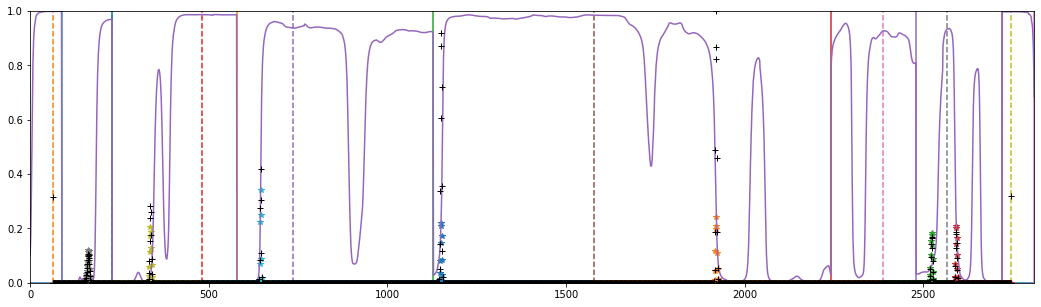

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in selected_frames_indices:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in boundary_frames_dict[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(selected_frames_indices[i], 
                   selected_frames_indices[i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]])
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames_indices[0] - 1, selected_frames_indices[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

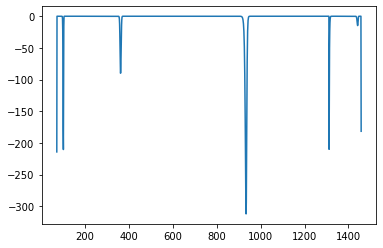

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

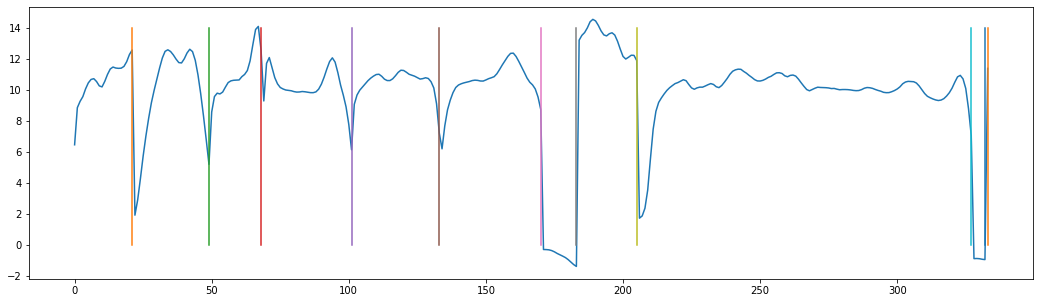

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss

In [22]:
def find_mask_for_this_class(video_len, weakly_labels_video, old_index_label_pair_list, 
                             cur_ele_searched, cur_index_searched):
    searched_label_index = np.where(cur_ele_searched == np.array(weakly_labels_video))[0]
    if len(searched_label_index) <= 1:
        mask = torch.ones(video_len)
        return mask
    else:
        start = 0
        for i, index in enumerate(searched_label_index[:-1]):
            cur_index_frame_selected = old_index_label_pair_list[index][0]
            next_index = searched_label_index[i + 1]
            next_index_frame_selected = old_index_label_pair_list[next_index][0]
            
            mid_select = (cur_index_frame_selected + next_index_frame_selected) // 2
            
            if index == cur_index_searched:
                mask = torch.zeros(video_len)
                mask[start: mid_select + 1] = 1
                return mask
            
            start = mid_select
        if searched_label_index[-1] == cur_index_searched:
            mask = torch.zeros(video_len)
            mask[start: video_len] = 1
            return mask
        else:
            import pdb
            pdb.set_trace()
            return "Error 1"
    return "Error"

In [23]:
# [2, 2, 2, 2, 3, 3, 4, 4, 3, 3, 2, 2, 2, 2]
find_mask_for_this_class(12, [2, 3, 4, 3,  2], [3, 5, 7, 8, 10], 4, 2)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])